# Catalyst Algorithm for SAG -- Project

by Xiangnan YUE

In [72]:
import scipy.io
mat = scipy.io.loadmat('../data/data_orsay_2017.mat')

In [73]:
Xtest, Xtrain, ytest, ytrain = mat['Xtest'], mat['Xtrain'], mat['ytest'], mat['ytrain']

In [74]:
Xtest.shape, Xtrain.shape, ytest.shape, ytrain.shape

((100000, 100), (10000, 100), (100000, 1), (10000, 1))

In [79]:
import numpy as np
import pandas as pd
import copy

%matplotlib inline

In [80]:
import matplotlib.pyplot as plt

In [84]:
### classical SAG

In [223]:
def SAG(X_train, y_train, X_test, y_test, func, 
                grad_func, loss_func, n_pass=50, 
                step_size=1, mu=0.0, method="fix"):
    # shape
    y_train = np.ravel(y_train)
    y_test = np.ravel(y_test)
    m,n = X_train.shape
    mt, nt = X_test.shape
    X_train_ = np.c_[X_train, np.ones(m)]
    X_test_ = np.c_[X_test, np.ones(mt)]
    idx_lis = np.arange(m)
    
    b = np.zeros(n+1)
    grad_matrix = np.zeros((m, n+1)) # store all the grad changed
    yy_grad = np.zeros(n+1) # create a yy_grad as the average
    err_train_aver = []
    err_test_aver = []
    loss_train_aver = []
    loss_test_aver = []
    hist_b = []
    
    Lk = 1.0/step_size
    
    aver_num = 0
    n_iter = 0
    for i in range(n_pass):
        for k in range(m):            
            idx = np.random.choice(idx_lis, 1)[0]  # select, with replacement
            n_iter += 1
            grad = grad_func(X_train_[idx], y_train[idx], b, mu)  # calculate the gradient
            yy_grad = yy_grad + 1.0/(m) * (grad - grad_matrix[idx, :])
            grad_matrix[idx, :] = copy.copy(grad)  # update the gradient matrix
            
            if method == "constant_step_size":
                b = b - (step_size * grad)
            elif method == "SGD":
                b = b - (step_size / np.sqrt(k+i*m+1) * grad)
            else: 
                Lk = lip_line_search(X_train_[idx], y_train[idx], b, mu, loss_func, grad_func, Lk)
                b = b - (1.0/ Lk * yy_grad)
            hist_b.append(b)
            
            if n_iter % 5000 == 0:
                loss_train_aver.append(loss_func(X_train_, y_train, b, mu))
                loss_test_aver.append(loss_func(X_test_, y_test, b, mu))
                err_train_aver.append(obsolute_err(X_train_, y_train, b, func))
                err_test_aver.append(obsolute_err(X_test_, y_test, b, func))

                print "pass = ", i, "n_iter = ", n_iter, \
                      "the err for train set is", \
                      err_train_aver[-1], "the err for test set is", err_test_aver[-1]
                            
    return loss_train_aver, loss_test_aver, err_train_aver, err_test_aver, hist_b


def grad_reg_logic(X, y, b, mu=0.0):
    y = np.ravel(y)
    temp = (- y / (1.0 + np.exp(y * X.dot(b))) * X) + (2 * mu * b)
    return temp

def logistic_reg_loss(X, y, b, mu=0.0):
    return np.mean(np.log(1 + np.exp(- y * X.dot(b)))) + mu* (np.linalg.norm(x=b, ord=2)**2)

def grad_reg_square(X, y, b, mu=0.0):
    y = np.ravel(y)
    return X*(X.dot(b) - y) + ( mu * b)

def square_reg_loss(X, y, b, mu=0.0):
    y = np.ravel(y)
    if len(X.shape) == 2 :
        m = X.shape[0]
        return 0.5 / m  * np.linalg.norm(x= X.dot(b)-y, ord=2)**2 + 0.5*mu* (np.linalg.norm(x=b, ord=2)**2)
    return 0.5 * np.linalg.norm(x= X.dot(b)-y, ord=2)**2 + 0.5*mu* (np.linalg.norm(x=b, ord=2)**2)

def lip_linreg(X, mu):
    """Lipschitz constant for squares loss"""    
    return np.linalg.norm(x=X, ord=2)**2 /X.shape[0] + 2*mu
    
def lip_logreg(X, mu):
    """Lipschitz constant for logistic loss"""    
    return np.linalg.norm(x=X, ord=2)**2 / 4 /X.shape[0] + 2*mu

def lip_line_search(xk, yk, b, mu, f, grad_f, Lk, max_search=20):
    if (f(xk, yk, b-(1.0/Lk)*grad_f(xk, yk, b, mu), mu) - f(xk, yk, b, mu)) <= 1.0/(2*Lk) * np.linalg.norm(grad_f(xk, yk, b, mu), ord=2)**2:
        return Lk
    else:
        for i in range(max_search):
            Lk = 2*Lk
            if (f(xk, yk, b-(1.0/Lk)*grad_f(xk, yk, b, mu), mu) - f(xk, yk, b, mu)) <= 1.0/(2*Lk) * np.linalg.norm(grad_f(xk, yk, b, mu), ord=2)**2:
                return Lk
        raise Exception("line Search Failed")
        
def func_linear(X, b):
    prob = (X.dot(b)+1)/2.0
    n = len(prob)
    prediction = np.zeros(n)
    for i in range(n):
        if prob[i] > 1.0/2:
            prediction[i] = 1
        else:
            prediction[i] = -1
    return prediction
            

def func_logit(X, b):
    prob = 1.0 /(1 + np.exp(-X.dot(b))) # (probability) of taking 1
    n = len(prob)
    prediction = np.zeros(n)
    for i in range(n):
        if prob[i] > 1.0/2:
            prediction[i] = 1
        else:
            prediction[i] = -1
    return prediction

def obsolute_err(X, y, b, func):
    return np.mean(a=np.int64(func(X, b) != y))

In [311]:
# for the case of regulation mu = 1e-1
sag_loss_train_reg_sq, sag_loss_test_reg_sq, sag_err_train_reg_sq, sag_err_test_reg_sq, hist_b_sq = SAG(Xtrain, ytrain, 
                                                                                    Xtest, ytest, func_linear, 
                                                                                    grad_reg_square, square_reg_loss, 
                                                                                    n_pass=20, step_size=1e-2, 
                                                                                    mu=1e-5, method="SAG")

pass =  0 n_iter =  5000 the err for train set is 0.2956 the err for test set is 0.29389
pass =  0 n_iter =  10000 the err for train set is 0.2629 the err for test set is 0.25937
pass =  1 n_iter =  15000 the err for train set is 0.2343 the err for test set is 0.2377
pass =  1 n_iter =  20000 the err for train set is 0.2358 the err for test set is 0.23767
pass =  2 n_iter =  25000 the err for train set is 0.2369 the err for test set is 0.24032
pass =  2 n_iter =  30000 the err for train set is 0.2266 the err for test set is 0.22909
pass =  3 n_iter =  35000 the err for train set is 0.2255 the err for test set is 0.22982
pass =  3 n_iter =  40000 the err for train set is 0.2266 the err for test set is 0.22728
pass =  4 n_iter =  45000 the err for train set is 0.2257 the err for test set is 0.22589
pass =  4 n_iter =  50000 the err for train set is 0.2267 the err for test set is 0.22537
pass =  5 n_iter =  55000 the err for train set is 0.2234 the err for test set is 0.22467
pass =  5 n_

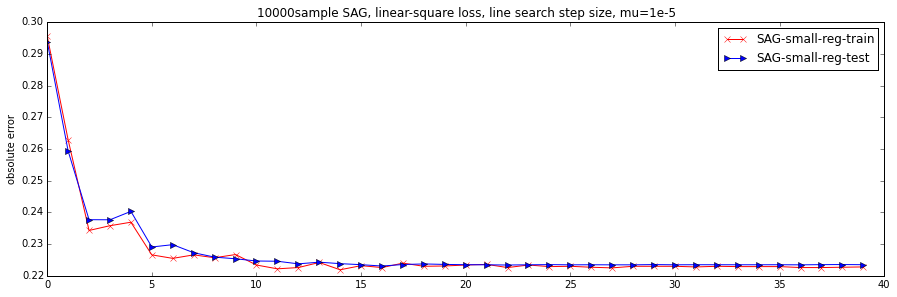

In [312]:
plt.figure(figsize=(15,10))
plt.subplot(2, 1, 1)
plt.plot(sag_err_train_reg_sq,marker="x", color='r')
plt.plot(sag_err_test_reg_sq, marker=">")
plt.legend(["SAG-small-reg-train", "SAG-small-reg-test"])
plt.ylabel("obsolute error")
plt.title(s="10000sample SAG, linear-square loss, line search step size, mu=1e-5")

### SAG converges about 15 passes of the data

In [152]:
### prepare implement catalyst
'''
G_k(x) = f(x) + g(x) + kapa/2 * np.linalg.norm(x - y, ord=2)**2
for proximal f,g = square, it's actually gradient,
we consider SAG case
'''
def grad_G_lin(X, y, b, z, mu, kapa):
    grad_F = grad_reg_square(X, y, b, mu)
    return grad_F + kapa*(b - z)

def G_lin(X, y, b, z, mu, kapa):
    loss = square_reg_loss(X, y, b, mu)
    return loss + kapa/2.0 * np.linalg.norm(x=b-z, ord=2)**2

def lip_line_search_cata(xk, yk, b, z, mu, kapa, f, grad_f, Lk, max_search=20):
    grad_f_v = grad_f(xk, yk, b, z, mu, kapa)
    if (f(xk, yk, b-(1.0/Lk)*grad_f_v, z, mu, kapa) - f(xk, yk, b, z, mu, kapa)) <= 1.0/(2*Lk) * np.linalg.norm(grad_f_v, ord=2)**2:
        return Lk
    else:
        for i in range(max_search):
            Lk = 2*Lk
            if (f(xk, yk, b-(1.0/Lk)*grad_f_v, z, mu, kapa) - f(xk, yk, b, z, mu, kapa)) <= 1.0/(2*Lk) * np.linalg.norm(grad_f_v, ord=2)**2:
                return Lk
        raise Exception("line Search Failed")

In [226]:
'''
remember that the duality gap can estimate the distance with the optimal value
'''
def dual_gap_G_lin(X, y, b, z, mu, kapa):
    m = X.shape[0]
    err = X.dot(b) - y
    Xerr = X.T.dot(err)
    dualgap = 1.0/m * np.linalg.norm(x=err, ord=2)**2 + 0.5*mu*b.dot(b) + kapa/2.0*np.linalg.norm(x=b-z, ord=2)**2
    dualgap = dualgap - kapa/m/(mu+kapa)*z.dot(Xerr) + 0.5/(mu+kapa)/(m*m)*(Xerr.dot(Xerr)) \
                    - kapa*mu*0.5/(mu+kapa)*z.dot(z) + 1.0/m*err.dot(y)
    return dualgap

# test
X = np.array([[1,2], [4,3], [5,6]])
y = np.array([0.2,-0.7, -0.2])
b = np.array([-0.4, 0.3])
z = np.array([0, 0])
dual_gap_G_lin(X, y, b, z, 0.2, kapa=0.4)

0.07500000000000007

In [316]:
def sga_cata(X_train_, y_train, X_test_, y_test, his_dual_gap,
                 loss_train_aver, loss_test_aver,
                 err_train_aver, err_test_aver,
                 func, dual_f, grad_func, loss_func, 
                 b_0, grad_matrix, z, mu, kapa, 
                 epsilon=1e-5, n_pass=20, 
                step_size=1, method="fix"):
    # shape
    m,n = X_train_.shape
    mt, nt = X_test_.shape
    idx_lis = np.arange(m)
    
    #b = np.zeros(n)
    b = b_0.copy()
    #grad_matrix = np.zeros((m, n)) # store all the grad changed
    #grad_matrix = copy.copy(grad_mat_0) 
    yy_grad = np.zeros(n) # create a yy_grad as the average
    hist_b = []
    
    Lk = 1.0/step_size
    
    aver_num = 0
    n_iter = 0
    for i in range(n_pass):
        for k in range(m):            
            idx = np.random.choice(idx_lis, 1)[0]  # select, with replacement
            n_iter += 1
            grad = grad_func(X_train_[idx], y_train[idx], b, z, mu, kapa)  # calculate the gradient
            yy_grad = yy_grad + 1.0/(m) * (grad - grad_matrix[idx, :])
            grad_matrix[idx, :] = copy.copy(grad)  # update the gradient matrix
            
            if method == "constant_step_size":
                b = b - (step_size * grad)
            elif method == "SGD":
                b = b - (step_size / np.sqrt(k+i*m+1) * grad)
            else: 
                Lk = lip_line_search_cata(X_train_[idx], y_train[idx], b, z, mu, kapa, loss_func, grad_func, Lk)
                b = b - (1.0/ Lk * yy_grad)
            
            hist_b.append(b)
            
            if n_iter % 5000 == 0:   
                loss_train_aver.append(loss_func(X_train_, y_train, b, z, mu, kapa))
                loss_test_aver.append(loss_func(X_test_, y_test, b, z, mu, kapa))
                err_train_aver.append(obsolute_err(X_train_, y_train, b, func))
                err_test_aver.append(obsolute_err(X_test_, y_test, b, func))
                his_dual_gap.append(dual_f(X_train_, y_train, b, z, mu=mu, kapa=kapa))
        
        print "pass = ", i, "n_iter = ", n_iter, \
              "the cost for train set is", \
              err_train_aver[-1], "the err for test set is", err_test_aver[-1]

        if his_dual_gap[-1] < epsilon:
            print "the dual gap =", his_dual_gap[-1], " is smaller than the epsilon_k = ", epsilon, "break"
            break
        else:
            print "the dual gap =", his_dual_gap[-1], " is larger than the epsilon_k = ", epsilon, "continue"
            
    return hist_b

In [320]:


def catalyst(X_train, y_train, X_test, y_test, func, grad_f, loss_f, dual_f,
             kapa=0.2, mu=1e-1, step_size=1, max_iter=100, max_inner=20):
    
    # shape
    y_train = np.ravel(y_train)
    y_test = np.ravel(y_test)
    m,n = X_train.shape
    mt, nt = X_test.shape
    X_train_ = np.c_[X_train, np.ones(m)]
    X_test_ = np.c_[X_test, np.ones(mt)]
    
    m, p = X_train_.shape
    x_k = np.zeros(p)  # b
    grad_matrix = np.zeros((m, p)) # for SAG
    z_k = copy.copy(x_k)  # add  |x -z_k-1|^2
    hist_x_k = [x_k]
    err_train = [obsolute_err(X_train_, y_train, x_k, func)]
    err_test = [obsolute_err(X_test_, y_test, x_k, func)]
    loss_train_reg_sq = [] 
    loss_test_reg_sq = []
    err_train_reg_sq = []
    err_test_reg_sq = []
    his_dual_gap = []
    
    q = mu / (mu+kapa)  # mu-strongly convex
    alpha_k = 0.5*(q-1 + np.sqrt((1-q)**2 + 4)) 
    rho_k = 0.9*np.sqrt(q)
    F_0 = loss_f(X_train_, y_train, x_k, z_k, mu, kapa) - kapa/2.0 * np.linalg.norm(x=x_k-z_k, ord=2)**2
    
    for k in range(max_iter):
        
        print "the", k, "th round start..."
        
        # compute epsilon_k
        epsilon_k = 2.0/9*F_0*(1-rho_k)**k
        x_k_old = x_k.copy()
        
        # start the inner loop in round k, here we pass grad_matrix as an object into the inner loop and
        # the previous results will be stored and reused as a warm start each time.
        # x_k will be copied in sga_cata, and thus not affected
        hist_x_sq = sga_cata(X_train_, y_train, X_test_, y_test, his_dual_gap,
                             loss_train_reg_sq, loss_test_reg_sq, 
                             err_train_reg_sq, err_test_reg_sq, 
                             func, dual_gap_G_lin, grad_f, loss_f, 
                             x_k, grad_matrix, z_k, mu, kapa, 
                            epsilon=epsilon_k,
                            n_pass=max_inner, 
                            step_size=step_size, 
                            method="SAG")
        # update and record
        x_k = hist_x_sq[-1]
        hist_x_k.append(x_k.copy())
        err_train.append(obsolute_err(X_train_, y_train, x_k, func))
        err_test.append(obsolute_err(X_test_, y_test, x_k, func))
        
        # compute alpha_k
        alpha_k_old = alpha_k.copy()
        alpha_k = 0.5 * (-(alpha_k**2 - q) + np.sqrt((alpha_k**2 - q)**2 + 4.0*alpha_k**2))
        #print "alpha_k = ", alpha_k
        
        # compute beta_k
        beta_k = alpha_k_old*(1-alpha_k_old)/(alpha_k_old**2 + alpha_k)
        
        # compute z_k
        z_k = x_k + beta_k*(x_k - x_k_old)
        
    return hist_x_k, his_dual_gap, err_train, err_test, loss_train_reg_sq, loss_test_reg_sq, err_train_reg_sq, err_test_reg_sq

In [321]:
hist_x_k, his_dual_gap, err_train, err_test, \
loss_train_reg_sq, loss_test_reg_sq, \
err_train_reg_sq, err_test_reg_sq = catalyst(Xtrain, ytrain, Xtest, ytest, func_linear, grad_G_lin, G_lin, dual_gap_G_lin,
                                         kapa=2e-4, mu=1e-5, step_size=1e-2, max_iter=4, max_inner=20)

the 0 th round start...
pass =  0 n_iter =  10000 the cost for train set is 0.2581 the err for test set is 0.25693
the dual gap = 57.565915887536114  is larger than the epsilon_k =  0.1111111111111111 continue
pass =  1 n_iter =  20000 the cost for train set is 0.2348 the err for test set is 0.23833
the dual gap = 13.985421190754248  is larger than the epsilon_k =  0.1111111111111111 continue
pass =  2 n_iter =  30000 the cost for train set is 0.2256 the err for test set is 0.22776
the dual gap = 6.8231745393785665  is larger than the epsilon_k =  0.1111111111111111 continue
pass =  3 n_iter =  40000 the cost for train set is 0.2292 the err for test set is 0.23019
the dual gap = 6.177826221160715  is larger than the epsilon_k =  0.1111111111111111 continue
pass =  4 n_iter =  50000 the cost for train set is 0.224 the err for test set is 0.2259
the dual gap = 4.158833826353357  is larger than the epsilon_k =  0.1111111111111111 continue
pass =  5 n_iter =  60000 the cost for train set i

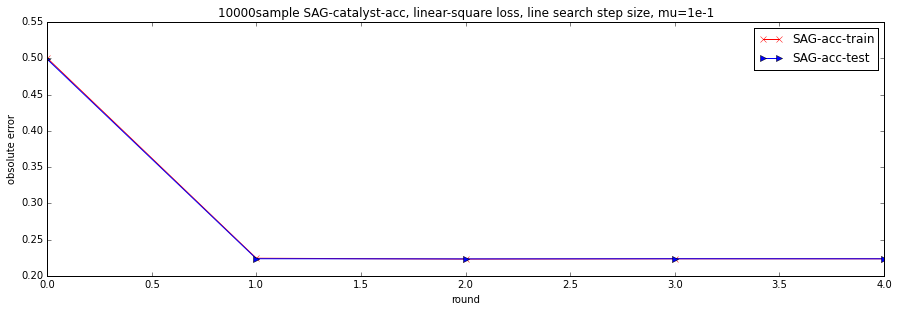

In [322]:
plt.figure(figsize=(15,10))
plt.subplot(2, 1, 1)
plt.plot(err_train,marker="x", color='r')
plt.plot(err_test, marker=">")
plt.xlabel("round")
plt.legend(["SAG-acc-train", "SAG-acc-test"])
plt.ylabel("obsolute error")
plt.title(s="10000sample SAG-catalyst-acc, linear-square loss, line search step size, mu=1e-1")

### We could see that the algorithm is convergent within 3 rounds, which is about 8 passes, and this outperforms the SAG.

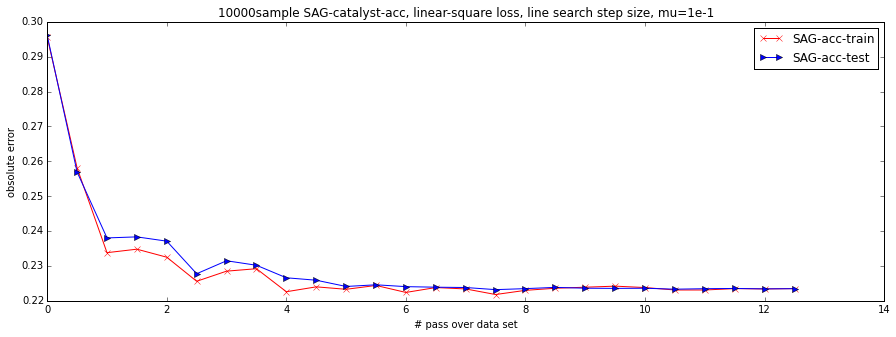

In [323]:
plt.figure(figsize=(15,5))
x_axis = np.arange(0, len(err_test_reg_sq)/2, 0.5)
plt.plot(x_axis,err_train_reg_sq, marker="x", color='r')
plt.plot(x_axis,err_test_reg_sq, marker=">")
plt.xlabel("# pass over data set")
plt.legend(["SAG-acc-train", "SAG-acc-test"])
plt.ylabel("obsolute error")
plt.title(s="10000sample SAG-catalyst-acc, linear-square loss, line search step size, mu=1e-1")

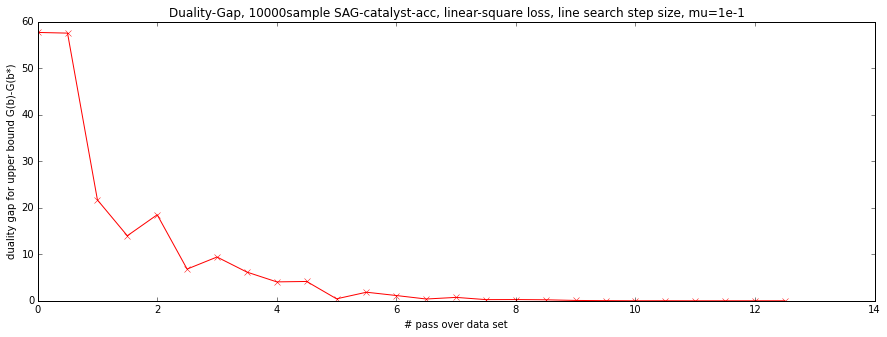

In [324]:
plt.figure(figsize=(15,5))
x_axis = np.arange(0, len(err_test_reg_sq)/2, 0.5)
plt.plot(x_axis,his_dual_gap, marker="x", color='r')
plt.xlabel("# pass over data set")
plt.ylabel("duality gap for upper bound G(b)-G(b*)")
plt.title(s="Duality-Gap, 10000sample SAG-catalyst-acc, linear-square loss, line search step size, mu=1e-1")

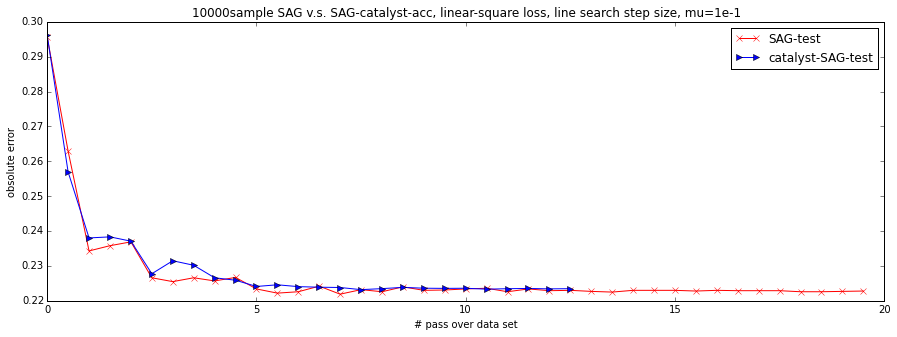

In [325]:
## compare
plt.figure(figsize=(15,5))
x_axis_1 = np.arange(0, len(sag_err_test_reg_sq)/2, 0.5)
x_axis_2 = np.arange(0, len(err_test_reg_sq)/2, 0.5)
plt.plot(x_axis_1,sag_err_train_reg_sq, marker="x", color='r')
plt.plot(x_axis_2,err_test_reg_sq, marker=">")
plt.xlabel("# pass over data set")
plt.legend(["SAG-test", "catalyst-SAG-test"])
plt.ylabel("obsolute error")
plt.title(s="10000sample SAG v.s. SAG-catalyst-acc, linear-square loss, line search step size, mu=1e-1")


In [304]:
def lip_linreg(X, mu):
    """Lipschitz constant for squares loss"""    
    return np.linalg.norm(x=X, ord=2)**2 /X.shape[0] + 2*mu

lip_linreg(Xtrain, mu=1e-2)

1.0275808982724313